# Querying a TensorFlow model hosted with TensorFlow Serving

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os

# STFSClient
from stfsclient import apis, config, sources, util, datasets

stfsclient.tensorflow_serving, using TF: False
stfsclient.tf_utils, using TF: False


## Import the Fashion MNIST dataset

The [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

![Fashion MNIST](https://tensorflow.org/images/fashion-mnist-sprite.png)

In [2]:
_, (test_images, test_labels) = datasets.fashion_mnist.load_data()

# preprocessing the data before inference
test_images = test_images / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('Shape: {}\nDType: {}'.format(test_images.shape, test_images.dtype))

Shape: (10000, 28, 28, 1)
DType: float64


## Run the server

A set of pre-trained models are provided as part of this tutorial along with an ascii `model_server_config.pbtxt` file.

Follow the [instructions](https://github.com/jagans94/stfsclient#installation) to setup the `tensorflow_model_server` on your system. Once, you've installed the model server, run the following commands in your terminal from the current directory.

```bash
rm -r /tmp/models
cp -r models /tmp/
```

followed by,

```bash
nohup tensorflow_model_server --port=8500 --rest_api_port=8501 --enable_batching --model_config_file=/tmp/models/model_server_config.pbtxt >server.log 2>&1 &
```

In [3]:
! tail server.log

2019-09-16 00:14:31.117740: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:54] Reading meta graph with tags { serve }
2019-09-16 00:14:31.127508: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:202] Restoring SavedModel bundle.
2019-09-16 00:14:31.147411: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:311] SavedModel load for tags { serve }; Status: success. Took 32929 microseconds.
2019-09-16 00:14:31.147455: I tensorflow_serving/servables/tensorflow/saved_model_bundle_factory.cc:100] Wrapping session to perform batch processing
2019-09-16 00:14:31.147471: I tensorflow_serving/servables/tensorflow/bundle_factory_util.cc:153] Wrapping session to perform batch processing
2019-09-16 00:14:31.147510: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:103] No warmup data file found at /tmp/models/fashion_model/1/assets.extra/tf_serving_warmup_requests
2019-09-16 00:14:31.147643: I tensorflow_serving/core/loader_harness.cc:86] Success

Your last few lines should be similar to this:

```bash
2019-09-15 17:32:28.843505: I tensorflow_serving/core/loader_harness.cc:86] Successfully loaded servable version {name: fashion_model version: 1}
2019-09-15 17:32:28.845849: I tensorflow_serving/model_servers/server.cc:324] Running gRPC ModelServer at 0.0.0.0:8500 ...
[evhttp_server.cc : 239] RAW: Entering the event loop ...
2019-09-15 17:32:28.846845: I tensorflow_serving/model_servers/server.cc:344] Exporting HTTP/REST API at:localhost:8501 ...
```

**Note:** We will be pinging the gRPC ModelServer using our client.

## Making requests to the Predict API

#### **[Predict API](https://github.com/tensorflow/serving/blob/5369880e9143aa00d586ee536c12b04e945a977c/tensorflow_serving/apis/prediction_service.proto#L23):** Returns output tensors.

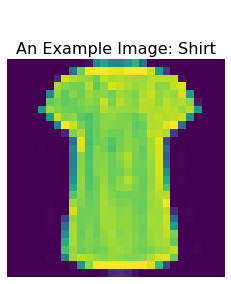

In [4]:
def show(idx, title):
    plt.figure()
    plt.imshow(test_images[idx].reshape(28,28))
    plt.axis('off')
    plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

Ok, that looks interesting. 
How hard is that for you to recognize? Now let's create a prediction request object for a batch of three inference requests, and see how well our model recognizes things:

In [5]:
batch_size = 3

In [6]:
model_spec = apis.ModelSpec(name='fashion_model', version=1, signature_name='serving_default')
predict_request = apis.PredictRequest(
    model_spec=model_spec,
    inputs={'input_image': test_images[:batch_size,:].astype(np.float32)})
prediction_service = apis.PredictionService('0.0.0.0:8500')
predict = prediction_service.predict

#### A couple of things:

- By specifying the version of the model in model_spec we can tell the server to serve our requests to a specific model.
- The signature_name specifies the SignatureDef used for binding inputs and outputs when exporting the model.
- Parameters like name, signature_name and input_image are defined while exporting the model.

In [7]:
predict_response = apis.PredictResponse()
predict_response = predict_response.copy(predict(predict_request._protobuf, 5))

In [8]:
def get_predictions(predict_response):
    predicted_labels = []
    for key, prediction in predict_response.parse_outputs().items():
        for i in range(batch_size):
            predicted_labels.append(class_names[np.argmax(prediction[i])])
    return predicted_labels

In [9]:
predictions = get_predictions(predict_response)

In [10]:
# Test here by changing the index value
index = 2

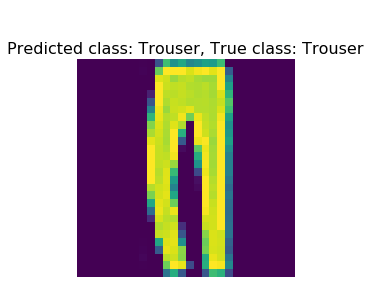

In [11]:
show(index, 
     'Predicted class: {}, True class: {}'.format(predictions[index], 
                                                 class_names[test_labels[index]]))

The model seems to be on mark! Remember your prediction is only as good as your data, so feed you model lots and lots of data to make it better.

## Making requests to Model Metadata, Model Status and Reload Config APIs

TensorFlow ModelServer also supports other APIs as well. This section describes these API
endpoints with end-to-end examples. The request and response is a 'protobuf' object, with the composition of this object depending on the request type.

The gRPC services accepts a 'protobuf' request object and returns a 'protobuf' response object respectively. The wrappers expose the internal 'protobuf' object through the `._protobuf` attribute.

#### Currently, 'stfsclient' supports only the above APIs, with plans to add more in the future, including some custom ones.

#### **[Model Metadata API](https://github.com/tensorflow/serving/blob/5369880e9143aa00d586ee536c12b04e945a977c/tensorflow_serving/apis/prediction_service.proto#L29):** It returns the metadata of a model in the ModelServer.

Let's say you want to know the metadata of the models hosted by a particular TensorFlow Model Server (in our case, `0.0.0.0.8500`). The request and response look something like this.

In [12]:
prediction_service = apis.PredictionService('0.0.0.0:8500')
get_model_metadata = prediction_service.get_model_metadata

In [13]:
get_metadata_request = apis.GetModelMetadataRequest(
    model_spec=apis.ModelSpec(name='mnist', version=1, signature_name='predict_images'), 
    metadata_field='signature_def')

In [14]:
get_metadata_response = apis.GetModelMetadataResponse()
get_metadata_response = get_metadata_response.copy(get_model_metadata(get_metadata_request._protobuf, 5))

In [15]:
get_metadata_response.model_spec

name: "mnist"
version {
  value: 1
}

In [16]:
get_metadata_response.metadata

{'signature_def': type_url: "type.googleapis.com/tensorflow.serving.SignatureDefMap"
value: "\n\305\001\n\017serving_default\022\261\001\n\036\n\006inputs\022\024\n\014tf_example:0\020\007\032\002\030\001\022G\n\007classes\022<\n%hash_table_Lookup/LookupTableFindV2:0\020\007\032\021\022\013\010\377\377\377\377\377\377\377\377\377\001\022\002\010\n\022)\n\006scores\022\037\n\010TopKV2:0\020\001\032\021\022\013\010\377\377\377\377\377\377\377\377\377\001\022\002\010\n\032\033tensorflow/serving/classify\n{\n\016predict_images\022i\n%\n\006images\022\033\n\003x:0\020\001\032\022\022\013\010\377\377\377\377\377\377\377\377\377\001\022\003\010\220\006\022$\n\006scores\022\032\n\003y:0\020\001\032\021\022\013\010\377\377\377\377\377\377\377\377\377\001\022\002\010\n\032\032tensorflow/serving/predict"
}

At this time, the ModelMetadata API only supports 'signature_def'. Knowing the 'signature_def' can help structuring queries to the model. 

**TO DO:** Parsing 'signature_def'.

#### **[Reload Config API](https://github.com/tensorflow/serving/blob/master/tensorflow_serving/apis/model_service.proto#L22):** Reloads the set of served models in the ModelServer.

Remember the `model_config_file=/tmp/models/model_server_config.pbtxt` argument we passed to the TensorFlow Model Server earlier. That file instructs Tensorflow Serving to load updated versions of the models specified in that configuration file at the specified locations on the disk/storage path.

Using this API TensorFlow Serving allows you to reload the config file dynamically at run-time, changing which models are served and how.

Here's two policies specifying the model version/s to be served,
1. Serve version #2 of the model
2. Serve all versions of the model

In [17]:
version_policy_1 = config.ServableVersionPolicy(specific=2) 
version_policy_2 = config.ServableVersionPolicy(_all=1)

This time we're going after the mnist model!!

In [18]:
def get_model_server_config(version_policy):
    if version_policy is not None:
        _config = [config.ModelConfig(name='mnist',
                                      base_path='/tmp/models/mnist',
                                      model_platform='tensorflow', 
                                      model_version_policy=version_policy),
                 ]
    else:
        _config = []
    
    model_server_config = config.ModelServerConfig()
    model_server_config.model_config_list.config = _config
    
    return model_server_config

One use case of chain assignment: It makes assigning values to nested values really easy!

**Note:** The models need to be present on the disk at the specified base path otherwise a gRPC error will be thrown.

In [19]:
model_service = apis.ModelService('0.0.0.0:8500')
reload_config = model_service.reload_config

### Load version #2

In [20]:
reload_config_request = apis.ReloadConfigRequest(config=get_model_server_config(version_policy_1))
reload_config(reload_config_request._protobuf, 5) # if successful returns an empty status

status {
}

#### Alright
Woohoo! That worked! Or did it? How to check that?
Well, we can try sending a 'get_model_status' rpc request to query the status of the model.

#### **[Model Status API](https://github.com/tensorflow/serving/blob/master/tensorflow_serving/apis/model_service.proto#L17):** It returns the status of a model in the ModelServer.

This API allows you to get the status of the model (including that of individual versions) and allows you to check whether a model is running or stopped.

In [21]:
get_model_status = model_service.get_model_status

In [22]:
get_model_status_request = apis.GetModelStatusRequest(
    model_spec=apis.ModelSpec(name='mnist', signature_name='predict_images'))
get_model_status(get_model_status_request._protobuf, 5)

model_version_status {
  version: 2
  state: AVAILABLE
  status {
  }
}
model_version_status {
  version: 1
  state: END
  status {
  }
}

You can also get the status of a specific version of the model, like this!

In [23]:
get_model_status_request = apis.GetModelStatusRequest(
    model_spec=apis.ModelSpec(name='mnist', version=1, signature_name='predict_images'))
get_model_status(get_model_status_request._protobuf, 5)

model_version_status {
  version: 1
  state: END
  status {
  }
}

**Summary:** Version 2 is running and 1 has been taken down.

### Load all versions

This time we are going to try loading all versions and see the difference from before!

In [24]:
reload_config_request = apis.ReloadConfigRequest(config=get_model_server_config(version_policy_2))
reload_config(reload_config_request._protobuf, 5) # if successful returns an empty status

status {
}

In [26]:
get_model_status_request = apis.GetModelStatusRequest(
    model_spec=apis.ModelSpec(name='mnist', signature_name='predict_images'))
get_model_status(get_model_status_request._protobuf, 5)

model_version_status {
  version: 2
  state: AVAILABLE
  status {
  }
}
model_version_status {
  version: 1
  state: AVAILABLE
  status {
  }
}

**Summary:** Both the versions are running.

### Unload all versions

In [27]:
reload_config_request = apis.ReloadConfigRequest(config=get_model_server_config(None))
reload_config(reload_config_request._protobuf, 5) # if successful returns an empty status

status {
}

In [28]:
get_model_status_request = apis.GetModelStatusRequest(
    model_spec=apis.ModelSpec(name='mnist', signature_name='predict_images'))
get_model_status(get_model_status_request._protobuf, 5)

model_version_status {
  version: 2
  state: END
  status {
  }
}
model_version_status {
  version: 1
  state: END
  status {
  }
}

**Summary:** All versions have been taken down.

### Don't forget to stop the TensorFlow Model Server!!